# LAB8 tutorial for Machine Learning <br/> Convolutional Neural Network
> 11912911 张子越

## LAB Assignment
### Exercise 1  Image Classifier(100 points )
Follow the above instructions of Image Classifier Training with PyTorch to train your own image classifier (using the [CIFAR10 dataset](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). 

Please try to improve performance of classification by trying different network structures (add layers, modify parameters and so on) and different training strategies (loss function, optimizer and so on). 

<font color='red' size=5>Note: Your accuracy in this exercise will directly determine your score.</font>

In [1]:
# cite: implemented in https://github.com/uoguelph-mlrg/Cutout
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
class Cutout(object):
    """
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
        	# (x,y)表示方形补丁的中心位置
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import datasets, transforms

torch.multiprocessing.set_sharing_strategy('file_system')

import warnings
warnings.filterwarnings("ignore") 

%matplotlib inline

n_epochs = 30
batch_size = 256
train_valid_split = 0.8
learning_rate = 0.1
random_seed = 1
num_workers = 0

torch.manual_seed(random_seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    Cutout(n_holes=1, length=16)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

trainlen = len(trainset)
indices = list(range(trainlen))
np.random.shuffle(indices)
split = int(train_valid_split * trainlen)
trainsampler = SubsetRandomSampler(indices[:split])
validsampler = SubsetRandomSampler(indices[split:])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=trainsampler, num_workers=num_workers)

validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=validsampler, num_workers=num_workers)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

len(trainloader), len(validloader), len(testloader)

Files already downloaded and verified
Files already downloaded and verified


(157, 40, 40)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


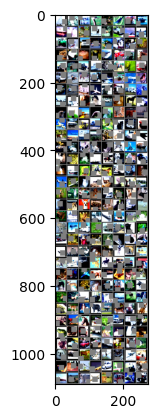

ship  plane plane bird  deer  plane horse ship  ship  deer  frog  deer  deer  car   plane ship  truck bird  truck car   bird  cat   frog  frog  cat   dog   cat   cat   ship  car   horse horse truck deer  truck ship  frog  horse frog  truck car   bird  deer  truck plane frog  plane bird  car   plane ship  plane ship  truck truck plane plane truck horse dog   car   cat   horse ship  bird  bird  plane bird  dog   frog  horse ship  plane car   truck truck bird  dog   car   car   deer  plane ship  frog  frog  dog   car   plane car   truck dog   dog   cat   plane plane ship  dog   frog  frog  ship  plane dog   cat   car   dog   ship  frog  bird  horse plane deer  cat   plane plane cat   bird  deer  bird  horse ship  deer  deer  car   dog   car   frog  cat   dog   cat   horse dog   frog  dog   dog   truck bird  frog  ship  deer  car   ship  ship  deer  deer  frog  plane truck bird  truck truck dog   horse truck frog  cat   horse frog  ship  cat   car   bird  bird  car   cat   bird  deer  dog 

In [3]:
import torchvision

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
# from torch.nn import functional
#
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)
#
#     def forward(self, x):
#         x = self.pool(functional.relu(self.conv1(x)))
#         x = self.pool(functional.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = functional.relu(self.fc1(x))
#         x = functional.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
#
#
# net = Net().to(device)
# print(net)

In [5]:
# import torch.optim as optim
#
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.5)

In [6]:
# # training
#
# from tqdm import tqdm
#
# history = {'Train Loss':[],'Test Loss':[],'Test Accuracy':[]}
#
# for epoch in range(1, n_epochs+1):  # loop over the dataset multiple times
#     processBar = tqdm(trainloader, unit='step')
#
#     train_loss_total = 0.0
#
#     net.train()
#
#     for step, (inputs, labels) in enumerate(processBar):
#         # get the inputs; data is a list of [inputs, labels]
#
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#
#         # zero the parameter gradients
#         optimizer.zero_grad()
#
#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#
#         predictions = torch.argmax(outputs, dim=1)
#         accuracy = torch.sum(predictions == labels)/labels.shape[0]
#
#         loss.backward()
#         optimizer.step()
#
#         processBar.set_description(
#             f'Training... [{epoch}/{n_epochs}] Loss: {loss.item():.4f}, Acc: {accuracy.item():.4f}'
#         )
#
#         # print statistics
#         train_loss_total += loss
#
#         if step == len(processBar) - 1:
#             correct, test_loss_total = 0,0
#             totalSize = 0
#             net.eval()
#             for testImgs, labels in testloader:
#                 testImgs = testImgs.to(device)
#                 labels = labels.to(device)
#
#                 outputs = net(testImgs)
#                 loss = criterion(outputs, labels)
#                 totalSize += labels.size(0)
#                 test_loss_total += loss
#                 predictions = torch.argmax(outputs, dim=1)
#                 correct += torch.sum(predictions == labels)
#
#             test_accuracy = correct / totalSize
#             test_loss_avg = test_loss_total / len(testloader)
#             train_loss_avg = train_loss_total / len(trainloader)
#
#             history['Train Loss'].append(train_loss_avg.item())
#             history['Test Loss' ].append(test_loss_avg.item())
#             history['Test Accuracy'].append(test_accuracy.item())
#             processBar.set_description(
#                 f'Testing... [{epoch}/{n_epochs}] Loss: {loss.item():.4f}, Acc: {accuracy.item():.4f}, Test Loss: {test_loss_avg.item():.4f}, Test Acc: {test_accuracy.item():.4f}'
#             )
#
#     processBar.close()
#
#
# print('Finished Training')

In [7]:
# # save the model
# PATH = './models/cifar10.pth'
#
# print(net)
# torch.save(net.state_dict(), PATH)

In [8]:
# # load the model
#
# model = Net()
# model.load_state_dict(torch.load(PATH))
# model.eval()

In [9]:
# #fig=plt.figure(figsize=(10, 8), dpi=60)
# #对测试Loss进行可视化
# plt.plot(history['Train Loss'],label = 'Train Loss')
# plt.plot(history['Test Loss'],label = 'Test Loss')
# plt.legend(loc='best')
# plt.grid(True)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()

In [10]:
# #对测试准确率进行可视化
# plt.plot(history['Test Accuracy'],color = 'red',label = 'Test Accuracy')
# plt.legend(loc='best')
# plt.grid(True)
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.show()

#### Test the network

In [11]:
# dataiter = iter(testloader)
# images, labels = next(dataiter)
#
# # print images
# imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [12]:
# net = Net()
# net.load_state_dict(torch.load(PATH))
#
# net.eval()
# outputs = net(images)
#
# _, predicted = torch.max(outputs, dim=1)
# print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

In [13]:
# correct = 0
# total = 0
# # since we're not training, we don't need to calculate the gradients for our outputs
# with torch.no_grad():
#     for data in testloader:
#         net.eval()
#         images, labels = data
#         images = images.to(device)
#         labels = labels.to(device)
#         # calculate outputs by running images through the network
#         outputs = net(images)
#         # the class with the highest energy is what we choose as prediction
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#
# print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

#### ResNet18

reference:
- https://zhuanlan.zhihu.com/p/515734064
- https://github.com/ZOMIN28/ResNet18_Cifar10_95.46

In [14]:
import torch
from torch import nn


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """
    3x3 convolution with padding
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False,
                     dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """
    1x1 convolution
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, down_sample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError('Dilation > 1 not implemented in BasicBlock')
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.down_sample = down_sample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block,  64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                # if isinstance(m, Bottleneck):
                #     nn.init.constant_(m.bn3.weight, 0)
                # elif isinstance(m, BasicBlock):
                #     nn.init.constant_(m.bn2.weight, 0)
                if isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        down_sample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            down_sample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, down_sample, self.groups,
                        self.base_width, previous_dilation, norm_layer)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))
        return nn.Sequential(*layers)


def _resnet(block, layers, **kwargs):
    model = ResNet(block, layers, **kwargs)
    return model


def ResNet18(**kwargs):
    return _resnet(BasicBlock, [2, 2, 2, 2], **kwargs)

##### Training

In [15]:
import torch
from torch import nn
from torch import optim
from tqdm import tqdm

#存储训练过程
history = {'Train Loss':[],'Valid Loss':[],'Valid Accuracy':[]}

n_epochs = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet18()
model.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = nn.Linear(512, len(classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)


lr = 0.1

for epoch in range(1, n_epochs+1):
    processBar = tqdm(trainloader, unit='step')

    if epoch % 10 == 0:
        lr *= 0.8
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    train_loss_total = 0.0

    model.train()
    for step, (inputs, labels) in enumerate(processBar):

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs).to(device)

        loss = criterion(outputs, labels)

        predictions = torch.argmax(outputs, dim=1)
        correct_num = torch.sum(predictions.eq(labels.data.view_as(predictions)))
        accuracy = correct_num / labels.shape[0]

        loss.backward()
        optimizer.step()

        processBar.set_description(f'[{epoch}/{n_epochs}] Loss: {loss.item():.4f}, Acc: {accuracy.item():.4f}')

        train_loss_total += loss

    processBar.close()

    ##########
    # validate model after training an epoch
    ##########
    correct_num_total = 0
    size_total = 0
    valid_loss_total = 0.0

    model.eval()
    with torch.no_grad():
        for (inputs, labels) in validloader:
            inputs = inputs.to(device)
            # print('valid',inputs.shape)
            labels = labels.to(device)

            outputs = model(inputs).to(device)

            loss = criterion(outputs, labels)

            predictions = torch.argmax(outputs, 1)
            correct_num = torch.sum(torch.eq(predictions, labels.data.view_as(predictions)))
            correct_num_total += correct_num

            size_total += labels.shape[0]
            valid_loss_total += loss

    valid_accuracy = correct_num_total / size_total
    valid_loss_avg = valid_loss_total / len(validloader)
    train_loss_avg = train_loss_total / len(trainloader)

    history['Train Loss'].append(train_loss_avg.item())
    history['Valid Loss'] .append(valid_loss_avg. item())
    history['Valid Accuracy'].append(valid_accuracy.item())

    print(f'[{epoch:d}/{n_epochs:d}] Valid Loss: {valid_loss_avg.item():.4f} Valid Acc: {valid_accuracy.item():.4f}')

[1/100] Loss: 1.6326, Acc: 0.4375: 100%|██████████| 157/157 [00:38<00:00,  4.09step/s]


[1/100] Valid Loss: 1.6301 Valid Acc: 0.3676


[2/100] Loss: 1.4635, Acc: 0.4375: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[2/100] Valid Loss: 1.5984 Valid Acc: 0.4283


[3/100] Loss: 1.0871, Acc: 0.5469: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[3/100] Valid Loss: 1.3100 Valid Acc: 0.5313


[4/100] Loss: 1.3590, Acc: 0.5938: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[4/100] Valid Loss: 1.1810 Valid Acc: 0.5800


[5/100] Loss: 1.1531, Acc: 0.5625: 100%|██████████| 157/157 [00:37<00:00,  4.16step/s]


[5/100] Valid Loss: 1.0796 Valid Acc: 0.6124


[6/100] Loss: 0.9644, Acc: 0.6719: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[6/100] Valid Loss: 1.2700 Valid Acc: 0.5677


[7/100] Loss: 0.7950, Acc: 0.7344: 100%|██████████| 157/157 [00:37<00:00,  4.16step/s]


[7/100] Valid Loss: 1.2117 Valid Acc: 0.6093


[8/100] Loss: 0.6084, Acc: 0.8125: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[8/100] Valid Loss: 0.9509 Valid Acc: 0.6623


[9/100] Loss: 0.9170, Acc: 0.6875: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[9/100] Valid Loss: 0.8413 Valid Acc: 0.7016


[10/100] Loss: 0.7755, Acc: 0.7656: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[10/100] Valid Loss: 0.6866 Valid Acc: 0.7654


[11/100] Loss: 0.5168, Acc: 0.8281: 100%|██████████| 157/157 [00:37<00:00,  4.17step/s]


[11/100] Valid Loss: 0.6786 Valid Acc: 0.7579


[12/100] Loss: 0.6668, Acc: 0.7812: 100%|██████████| 157/157 [00:37<00:00,  4.16step/s]


[12/100] Valid Loss: 0.7332 Valid Acc: 0.7465


[13/100] Loss: 0.4478, Acc: 0.8281: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[13/100] Valid Loss: 0.6977 Valid Acc: 0.7577


[14/100] Loss: 0.5512, Acc: 0.7969: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[14/100] Valid Loss: 0.6867 Valid Acc: 0.7628


[15/100] Loss: 0.5464, Acc: 0.7969: 100%|██████████| 157/157 [00:37<00:00,  4.17step/s]


[15/100] Valid Loss: 0.7321 Valid Acc: 0.7408


[16/100] Loss: 0.4593, Acc: 0.8750: 100%|██████████| 157/157 [00:37<00:00,  4.17step/s]


[16/100] Valid Loss: 0.6072 Valid Acc: 0.7878


[17/100] Loss: 0.3957, Acc: 0.8594: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[17/100] Valid Loss: 0.6556 Valid Acc: 0.7726


[18/100] Loss: 0.4021, Acc: 0.9062: 100%|██████████| 157/157 [00:37<00:00,  4.23step/s]


[18/100] Valid Loss: 0.7694 Valid Acc: 0.7398


[19/100] Loss: 0.2874, Acc: 0.8594: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[19/100] Valid Loss: 0.6158 Valid Acc: 0.7889


[20/100] Loss: 0.3072, Acc: 0.8750: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[20/100] Valid Loss: 0.4911 Valid Acc: 0.8310


[21/100] Loss: 0.3129, Acc: 0.9375: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[21/100] Valid Loss: 0.4856 Valid Acc: 0.8280


[22/100] Loss: 0.3878, Acc: 0.8906: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[22/100] Valid Loss: 0.4721 Valid Acc: 0.8414


[23/100] Loss: 0.2709, Acc: 0.9219: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[23/100] Valid Loss: 0.4777 Valid Acc: 0.8398


[24/100] Loss: 0.2408, Acc: 0.8906: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[24/100] Valid Loss: 0.4620 Valid Acc: 0.8401


[25/100] Loss: 0.4118, Acc: 0.8906: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[25/100] Valid Loss: 0.4376 Valid Acc: 0.8520


[26/100] Loss: 0.4038, Acc: 0.8438: 100%|██████████| 157/157 [00:37<00:00,  4.24step/s]


[26/100] Valid Loss: 0.4900 Valid Acc: 0.8338


[27/100] Loss: 0.1950, Acc: 0.9062: 100%|██████████| 157/157 [00:37<00:00,  4.23step/s]


[27/100] Valid Loss: 0.4918 Valid Acc: 0.8283


[28/100] Loss: 0.5147, Acc: 0.7969: 100%|██████████| 157/157 [00:37<00:00,  4.24step/s]


[28/100] Valid Loss: 0.4728 Valid Acc: 0.8431


[29/100] Loss: 0.4597, Acc: 0.8594: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[29/100] Valid Loss: 0.4641 Valid Acc: 0.8347


[30/100] Loss: 0.2187, Acc: 0.9062: 100%|██████████| 157/157 [00:37<00:00,  4.23step/s]


[30/100] Valid Loss: 0.3789 Valid Acc: 0.8683


[31/100] Loss: 0.3517, Acc: 0.8438: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[31/100] Valid Loss: 0.4002 Valid Acc: 0.8620


[32/100] Loss: 0.1997, Acc: 0.9219: 100%|██████████| 157/157 [00:37<00:00,  4.23step/s]


[32/100] Valid Loss: 0.3882 Valid Acc: 0.8694


[33/100] Loss: 0.1625, Acc: 0.9375: 100%|██████████| 157/157 [00:37<00:00,  4.22step/s]


[33/100] Valid Loss: 0.3655 Valid Acc: 0.8762


[34/100] Loss: 0.2576, Acc: 0.8750: 100%|██████████| 157/157 [00:37<00:00,  4.23step/s]


[34/100] Valid Loss: 0.3857 Valid Acc: 0.8699


[35/100] Loss: 0.3904, Acc: 0.8438: 100%|██████████| 157/157 [00:37<00:00,  4.24step/s]


[35/100] Valid Loss: 0.3928 Valid Acc: 0.8660


[36/100] Loss: 0.2268, Acc: 0.9219: 100%|██████████| 157/157 [00:37<00:00,  4.23step/s]


[36/100] Valid Loss: 0.4150 Valid Acc: 0.8645


[37/100] Loss: 0.3108, Acc: 0.9219: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[37/100] Valid Loss: 0.3977 Valid Acc: 0.8693


[38/100] Loss: 0.2029, Acc: 0.9531: 100%|██████████| 157/157 [00:37<00:00,  4.24step/s]


[38/100] Valid Loss: 0.3967 Valid Acc: 0.8713


[39/100] Loss: 0.1585, Acc: 0.9062: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[39/100] Valid Loss: 0.4006 Valid Acc: 0.8658


[40/100] Loss: 0.2260, Acc: 0.9219: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[40/100] Valid Loss: 0.3562 Valid Acc: 0.8863


[41/100] Loss: 0.0935, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[41/100] Valid Loss: 0.3436 Valid Acc: 0.8867


[42/100] Loss: 0.1056, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[42/100] Valid Loss: 0.3531 Valid Acc: 0.8817


[43/100] Loss: 0.1708, Acc: 0.9062: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[43/100] Valid Loss: 0.3504 Valid Acc: 0.8852


[44/100] Loss: 0.2879, Acc: 0.9062: 100%|██████████| 157/157 [00:37<00:00,  4.24step/s]


[44/100] Valid Loss: 0.3399 Valid Acc: 0.8875


[45/100] Loss: 0.1500, Acc: 0.9531: 100%|██████████| 157/157 [00:37<00:00,  4.23step/s]


[45/100] Valid Loss: 0.3517 Valid Acc: 0.8820


[46/100] Loss: 0.1236, Acc: 0.9219: 100%|██████████| 157/157 [00:37<00:00,  4.23step/s]


[46/100] Valid Loss: 0.3562 Valid Acc: 0.8840


[47/100] Loss: 0.2164, Acc: 0.9219: 100%|██████████| 157/157 [00:37<00:00,  4.22step/s]


[47/100] Valid Loss: 0.3453 Valid Acc: 0.8855


[48/100] Loss: 0.2732, Acc: 0.9062: 100%|██████████| 157/157 [00:37<00:00,  4.23step/s]


[48/100] Valid Loss: 0.3679 Valid Acc: 0.8799


[49/100] Loss: 0.1525, Acc: 0.9375: 100%|██████████| 157/157 [00:37<00:00,  4.23step/s]


[49/100] Valid Loss: 0.3586 Valid Acc: 0.8880


[50/100] Loss: 0.0423, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.23step/s]


[50/100] Valid Loss: 0.3246 Valid Acc: 0.8960


[51/100] Loss: 0.2038, Acc: 0.9375: 100%|██████████| 157/157 [00:37<00:00,  4.24step/s]


[51/100] Valid Loss: 0.3212 Valid Acc: 0.8959


[52/100] Loss: 0.1073, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.24step/s]


[52/100] Valid Loss: 0.3308 Valid Acc: 0.8973


[53/100] Loss: 0.1526, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[53/100] Valid Loss: 0.3345 Valid Acc: 0.8923


[54/100] Loss: 0.1040, Acc: 0.9531: 100%|██████████| 157/157 [00:37<00:00,  4.24step/s]


[54/100] Valid Loss: 0.3190 Valid Acc: 0.9010


[55/100] Loss: 0.1109, Acc: 0.9688: 100%|██████████| 157/157 [00:36<00:00,  4.25step/s]


[55/100] Valid Loss: 0.3147 Valid Acc: 0.8960


[56/100] Loss: 0.0869, Acc: 0.9688: 100%|██████████| 157/157 [00:36<00:00,  4.25step/s]


[56/100] Valid Loss: 0.3294 Valid Acc: 0.8938


[57/100] Loss: 0.2367, Acc: 0.8906: 100%|██████████| 157/157 [00:37<00:00,  4.24step/s]


[57/100] Valid Loss: 0.3142 Valid Acc: 0.8979


[58/100] Loss: 0.1610, Acc: 0.9531: 100%|██████████| 157/157 [00:36<00:00,  4.25step/s]


[58/100] Valid Loss: 0.3222 Valid Acc: 0.8955


[59/100] Loss: 0.0301, Acc: 1.0000: 100%|██████████| 157/157 [00:36<00:00,  4.26step/s]


[59/100] Valid Loss: 0.3285 Valid Acc: 0.8999


[60/100] Loss: 0.0912, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[60/100] Valid Loss: 0.3247 Valid Acc: 0.8946


[61/100] Loss: 0.0992, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.24step/s]


[61/100] Valid Loss: 0.3131 Valid Acc: 0.9002


[62/100] Loss: 0.1306, Acc: 0.9375: 100%|██████████| 157/157 [00:37<00:00,  4.23step/s]


[62/100] Valid Loss: 0.3063 Valid Acc: 0.9017


[63/100] Loss: 0.1570, Acc: 0.9531: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[63/100] Valid Loss: 0.3088 Valid Acc: 0.9022


[64/100] Loss: 0.0640, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[64/100] Valid Loss: 0.3182 Valid Acc: 0.9007


[65/100] Loss: 0.0751, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.23step/s]


[65/100] Valid Loss: 0.3110 Valid Acc: 0.9013


[66/100] Loss: 0.1136, Acc: 0.9531: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[66/100] Valid Loss: 0.3144 Valid Acc: 0.9007


[67/100] Loss: 0.1387, Acc: 0.9375: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[67/100] Valid Loss: 0.3050 Valid Acc: 0.9011


[68/100] Loss: 0.2559, Acc: 0.9062: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[68/100] Valid Loss: 0.3057 Valid Acc: 0.9007


[69/100] Loss: 0.2540, Acc: 0.9219: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[69/100] Valid Loss: 0.3165 Valid Acc: 0.9004


[70/100] Loss: 0.0175, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[70/100] Valid Loss: 0.3095 Valid Acc: 0.9035


[71/100] Loss: 0.0903, Acc: 0.9531: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[71/100] Valid Loss: 0.3051 Valid Acc: 0.9031


[72/100] Loss: 0.1187, Acc: 0.9375: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[72/100] Valid Loss: 0.3105 Valid Acc: 0.9023


[73/100] Loss: 0.0967, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.24step/s]


[73/100] Valid Loss: 0.3207 Valid Acc: 0.9004


[74/100] Loss: 0.0408, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[74/100] Valid Loss: 0.3232 Valid Acc: 0.9021


[75/100] Loss: 0.0706, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[75/100] Valid Loss: 0.3144 Valid Acc: 0.9046


[76/100] Loss: 0.0795, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[76/100] Valid Loss: 0.3070 Valid Acc: 0.9074


[77/100] Loss: 0.1041, Acc: 0.9531: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[77/100] Valid Loss: 0.3249 Valid Acc: 0.8976


[78/100] Loss: 0.1010, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.18step/s]


[78/100] Valid Loss: 0.3171 Valid Acc: 0.9038


[79/100] Loss: 0.0194, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.24step/s]


[79/100] Valid Loss: 0.3112 Valid Acc: 0.9036


[80/100] Loss: 0.1167, Acc: 0.9531: 100%|██████████| 157/157 [00:37<00:00,  4.22step/s]


[80/100] Valid Loss: 0.3110 Valid Acc: 0.9041


[81/100] Loss: 0.0653, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.22step/s]


[81/100] Valid Loss: 0.3099 Valid Acc: 0.9004


[82/100] Loss: 0.0603, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.22step/s]


[82/100] Valid Loss: 0.3251 Valid Acc: 0.9019


[83/100] Loss: 0.0522, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[83/100] Valid Loss: 0.3058 Valid Acc: 0.9041


[84/100] Loss: 0.1703, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.24step/s]


[84/100] Valid Loss: 0.3221 Valid Acc: 0.9052


[85/100] Loss: 0.0110, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.23step/s]


[85/100] Valid Loss: 0.3241 Valid Acc: 0.9040


[86/100] Loss: 0.0862, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[86/100] Valid Loss: 0.3162 Valid Acc: 0.9024


[87/100] Loss: 0.0439, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.22step/s]


[87/100] Valid Loss: 0.3245 Valid Acc: 0.9019


[88/100] Loss: 0.0429, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.23step/s]


[88/100] Valid Loss: 0.3218 Valid Acc: 0.8990


[89/100] Loss: 0.0754, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.24step/s]


[89/100] Valid Loss: 0.3237 Valid Acc: 0.9036


[90/100] Loss: 0.0547, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[90/100] Valid Loss: 0.3152 Valid Acc: 0.9017


[91/100] Loss: 0.2243, Acc: 0.9531: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[91/100] Valid Loss: 0.3056 Valid Acc: 0.9037


[92/100] Loss: 0.0503, Acc: 1.0000: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[92/100] Valid Loss: 0.3258 Valid Acc: 0.9041


[93/100] Loss: 0.0289, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.21step/s]


[93/100] Valid Loss: 0.3102 Valid Acc: 0.9033


[94/100] Loss: 0.0703, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.22step/s]


[94/100] Valid Loss: 0.3214 Valid Acc: 0.9052


[95/100] Loss: 0.0402, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.22step/s]


[95/100] Valid Loss: 0.3247 Valid Acc: 0.9061


[96/100] Loss: 0.0616, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.22step/s]


[96/100] Valid Loss: 0.3136 Valid Acc: 0.9033


[97/100] Loss: 0.0872, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.19step/s]


[97/100] Valid Loss: 0.3021 Valid Acc: 0.9006


[98/100] Loss: 0.1393, Acc: 0.9688: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[98/100] Valid Loss: 0.3188 Valid Acc: 0.9024


[99/100] Loss: 0.1179, Acc: 0.9531: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[99/100] Valid Loss: 0.3087 Valid Acc: 0.9035


[100/100] Loss: 0.1067, Acc: 0.9844: 100%|██████████| 157/157 [00:37<00:00,  4.20step/s]


[100/100] Valid Loss: 0.3065 Valid Acc: 0.9097


In [16]:
correct_num_total = 0
size_total = 0
test_loss_total = 0.0

model.eval()
with torch.no_grad():
    for (inputs, labels) in testloader:
        inputs = inputs.to(device)
        # print('test',inputs.shape)
        labels = labels.to(device)

        outputs = model(inputs).to(device)

        loss = criterion(outputs, labels)

        predictions = torch.argmax(outputs, 1)
        correct_num = torch.sum(torch.eq(predictions, labels.data.view_as(predictions)))
        correct_num_total += correct_num

        size_total += labels.shape[0]
        test_loss_total += loss

test_accuracy = correct_num_total / size_total
test_loss_avg = test_loss_total / len(testloader)

print(f'Test Loss: {test_loss_avg.item():.4f} Test Acc: {test_accuracy.item():.4f}')

Test Loss: 0.2206 Test Acc: 0.9368


In [17]:
# save the model
PATH = 'cifar10_best.pth'

print(model)
torch.save(model.state_dict(), PATH)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

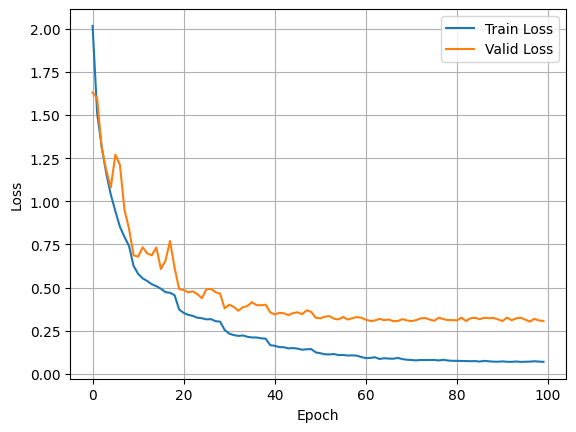

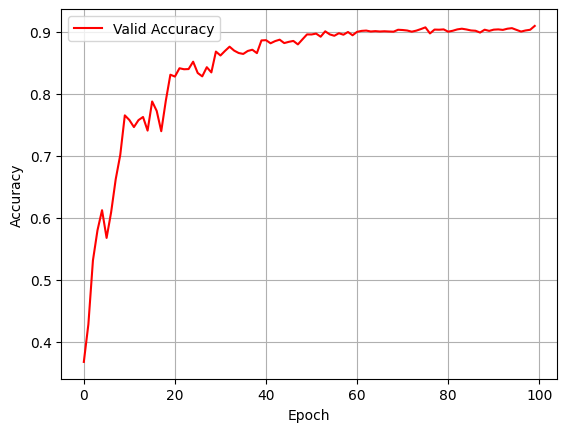

In [18]:
#对测试Loss进行可视化
plt.plot(history['Train Loss'],label = 'Train Loss')
plt.plot(history['Valid Loss'],label = 'Valid Loss')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#对测试准确率进行可视化
plt.plot(history['Valid Accuracy'],color = 'red',label = 'Valid Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### Exercise 2  Questions (4 points )
1. Can neural networks be used for unsupervised clustering or data dimension reduction? Why?

2. What are the strengths of neural networks; when do they perform well?

3. What are the weaknesses of neural networks; when do they perform poorly?

4. What makes neural networks a good candidate for the classification regression problem, if you have enough knowledge about the data?

Answer:
=======

(1): 

Yes. For example, autoencoder can learn high-dimension input data and output low-dimension data, thus can be used to reduce dimension. The high-dimensional data are first encoded to reduce its dimension, then it uses decoder to recover the original data.

(2):

1.Neural networks can learn enormous data while traditional methods can't.
2.They can map all kinds of relationship while user don't have to choose model or examine the data beforehand.
3.Neural networks have strong learning ability to learn from numerous high-dimensional features.
4.Strong generalization ability.

It performs well when there are sufficient training data.

(3):

1.Neural networks are complicated, the parameters have large space complexity, the training and prediction have large time complexity.
2.Neural networks are hard to understand, so it is hard to improve.
3.Requre large amounts of data.

It performs poorly when the parameters are not good, or the network structure is wrong, or the data contains too many errors, or the dataset is too small.

(4):

1.Neural networks can fit all kinds of relationships.
2.Datasets are easy to construct when we have enough knowledge about the data.

